# YOLOX-L 모델을 최적화 옵션을 적용해 컴파일하고 실행하기

퓨리오사 SDK는 모델을 최적으로 컴파일하고 실행하기 위한 여러 옵션을 제공합니다. 이 문서는 퓨리오사 SDK가 제공하는 옵션을 사용해서 YOLOX-L 모델을 보다 최적으로 컴파일하고 실행하는 예를 보입니다.

## 1. 준비

이 문서에 포함된 예제를 실행하려면, 퓨리오사 SDK 필수 리눅스 패키지 최신 버전을 설치하고 파이썬 실행 환경을 구축해야 합니다. 리눅스 패키지를 아직 설치하지 않았거나 파이썬 실행 환경을 구성하지 않았다면, 아래 두 문서를 참고해 준비할 수 있습니다:

* [드라이버, 펌웨어, 런타임 설치 가이드](https://furiosa-ai.github.io/docs/latest/ko/software/installation.html)
* [Python 실행 환경 구성](https://furiosa-ai.github.io/docs/latest/ko/software/python-sdk.html#python)

필수 리눅스 패키지와 파이썬 실행 환경을 준비하고 나면, 다음 단계로 퓨리오사 SDK 파이썬 패키지와 양자화 도구 추가 패키지 최신 버전을 설치합니다.

```console
$ pip3 install --upgrade 'furiosa-sdk[quantizer]'
```

마지막으로, OpenCV에 대한 파이썬 바인딩인 `opencv-python-headless` 패키지가 필요합니다. 아래에서 이미지 파일을 읽어 들이고 전처리를 하기 위해 사용합니다.

```console
$ pip3 install opencv-python-headless
```

### 1.1 YOLOX-L 모델

YOLOX-L 모델 구현으로는 Megvii 사가 [공개](https://yolox.readthedocs.io/en/latest/demo/onnx_readme.html)한 ONNX 모델 [yolox_l.onnx](https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_l.onnx)을 사용합니다. 해당 모델을 다운로드해서 현재 디렉토리에 저장합니다.

```console
$ wget https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_l.onnx
```

### 1.2 데이터 집합

양자화 패라미터를 결정하기 위한 캘리브레이션 데이터 집합과 성능을 측정하기 위한 테스트 데이터 집합으로 [COCO 데이터 집합](https://cocodataset.org)을 사용합니다. 2017년도 [검증 데이터 집합](http://images.cocodataset.org/zips/val2017.zip) (1 GB)과 [테스트 데이터 집합](http://images.cocodataset.org/zips/test2017.zip) (6 GB)을 내려 받습니다. 아래 `tree` 명령 출력과 같은 디렉토리 구조를 가지도록, 현재 디렉토리 아래에 `coco` 디렉토리를 만들고 다시 그 `coco` 디렉토리 속으로 내려 받은 데이터 집합 압축 파일들을 풀어 줍니다.

```console
$ mkdir coco

$ wget http://images.cocodataset.org/zips/val2017.zip
$ unzip -d coco val2017.zip

$ wget http://images.cocodataset.org/zips/test2017.zip
$ unzip -d coco test2017.zip

$ tree coco
coco
├── test2017
│   ├── 000000000001.jpg
│   ├── 000000000016.jpg
│   ├── 000000000019.jpg
│   ...
│   ├── 000000581911.jpg
│   └── 000000581918.jpg
└── val2017
    ├── 000000000139.jpg
    ├── 000000000285.jpg
    ├── 000000000632.jpg
    ...
    ├── 000000581615.jpg
    └── 000000581781.jpg

```

그리고 각 클래스 id에 해당하는 라벨 정보도 필요합니다.
```
$ wget https://github.com/amikelive/coco-labels/blob/master/coco-labels-2014_2017.txt
$ ls 
coco-labels-2014_2017.txt
```

### 1.3 임포트

In [1]:
import glob
from itertools import islice
import time

import cv2
import numpy as np
import onnx
import torch
import torchvision
import tqdm

import furiosa.native_runtime
from furiosa.optimizer import optimize_model
from furiosa.quantizer import quantize, Calibrator, CalibrationMethod, ModelEditor, TensorType

/home/furiosa/miniconda3/envs/f-10/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
libfuriosa_hal.so --- v0.11.0, built @ 43c901f
libfuriosa_hal.so --- v0.11.0, built @ 43c901f


## 2. YOLOX-L 모델

YOLOX-L 모델을 메모리로 읽어 들입니다.

In [2]:
model = onnx.load_model("models/yolox_m.onnx")

해당 모델은 아래 `calibrate_preproc` 함수를 사용해 전처리한 이미지 데이터 집합을 사용해 훈련되어 있습니다. `calibrate_preproc` 전처리 함수가 하는 일을 구체적으로 기술하면, 2번째 줄부터 13번째 줄까지는 이미지 데이터 크기를 모델 입력 크기로 변환합니다. 원본 이미지 가로세로비를 그대로 유지한 채 확대 혹은 축소하고, 여백을 값 114을 가진 픽셀들로 채웁니다. 그 다음, 15번째 줄에서 채널(C) 축을 맨 앞으로 옮깁니다. 즉, HxWxC 형태의 데이터를 CxHxW 형태의 데이터로 변환합니다. 마지막으로 16번째 줄에서 uint8 값을 float32 값으로 변환합니다. 전체적으로, 이미지를 다루는 모델 입력에 대해 자주 사용하는 전처리 유형입니다.

https://github.com/Megvii-BaseDetection/YOLOX/blob/68408b4083f818f50aacc29881e6f97cd19fcef2/yolox/data/data_augment.py#L142-L158

In [3]:
def calibrate_preproc(img, input_size, swap=(2, 0, 1)):
    if len(img.shape) == 3:  # line 2
        padded_img = np.ones((input_size[0], input_size[1], 3), dtype=np.uint8) * 114
    else:
        padded_img = np.ones(input_size, dtype=np.uint8) * 114

    r = min(input_size[0] / img.shape[0], input_size[1] / img.shape[1])
    resized_img = cv2.resize(
        img,
        (int(img.shape[1] * r), int(img.shape[0] * r)),
        interpolation=cv2.INTER_LINEAR,
    ).astype(np.uint8)
    padded_img[
        : int(img.shape[0] * r), : int(img.shape[1] * r)
    ] = resized_img  # line 13

    padded_img = padded_img.transpose(swap)  # line 15
    padded_img = np.ascontiguousarray(padded_img, dtype=np.float32)  # line 16
    return padded_img, r

## 3. 캘리브레이션과 양자화

양자화 패라미터를 결정하기 위해 사용할 캘리브레이션 데이터 집합을 준비합니다. 이 예에서는 빠른 시연을 위해 임의로 COCO 검증 데이터 집합에 속한 100개의 이미지를 사용합니다. 참고로, MLPerf 벤치마크는 500개 이미지를 캘리브레이션 데이터 집합으로 사용합니다. 훈련할 때 사용한 전처리(`calibrate_preproc`)와 동일한 전처리를 사용하는 점에 주목합니다. 2번째 줄에서 `[np.newaxis, ...]` 부분은 CxHxW 모양의 데이터를 모델 입력이 요구하는 1xCxHxW 모양의 값으로 변환합니다.

In [4]:
calibration_dataset = [
    calibrate_preproc(cv2.imread(image), (640, 640))[0][np.newaxis, ...]  # line 2
    for image in islice(glob.iglob("coco/val2017/*.jpg"), 1)
]

In [5]:
model = optimize_model(model)

앞에서 준비한 YOLOX-L 모델과 캘리브레이션 데이터 집합을 이용하여 캘리브레이션과 양자화를 수행합니다. 

In [6]:
calibrator = Calibrator(model, CalibrationMethod.MIN_MAX_ASYM)

for calibration_data in tqdm.tqdm(
    calibration_dataset, desc="Calibration", unit="images", mininterval=0.5
):
    calibrator.collect_data([[calibration_data]])

Calibration: 100%|██████████| 1/1 [00:01<00:00,  1.57s/images]


In [7]:
ranges = calibrator.compute_range()

위의 `range`는 각 텐서마다의 calibration range를 가지고 있습니다.

그리고 dictionary형태로 값을 저장하기 때문에 필요에 따라 다양한 데이터포멧으로 저장하고 불러올 수 있습니다.

밑의 예제는 json으로 저장하고 불러오는 예시입니다.

In [8]:
import json

with open("yolo_ranges.json", "w") as f:
    f.write(json.dumps(ranges, indent=4))
with open("yolo_ranges.json", "r") as f:
    ranges = json.load(f)

## 4. 컴파일 최적화 옵션

퓨리오사 SDK는 사용자가 컴파일 과정의 다양한 단계를 대상 모델에 맞게 미세 조정할 수 있도록 하는 여러 옵션을 제공합니다. 그러한 옵션 중의 하나로 이미지 관련 모델에서 자주 사용하는 형태의 전처리 코드의 일부를 퓨리오사 NPU 환경 하에서 보다 효율적으로 실행할 수 있는 코드로 변환하는 옵션이 있습니다. 

이 옵션들을 사용하기 위해서 `ModelEditor`를 제공하고 있습니다.

In [9]:
furiosa_editor = ModelEditor(model)

추가적인 성능을 위해서 모델의 입력/출력의 데이터타입을 바꾸어야 합니다.

모델의 입력 타입을 u8타입으로 출력 타입을 i8타입으로 바꾸기 위해 다음과 같이 실행을 합니다.

In [10]:
print(dir(ModelEditor))
# use model input tensor which name is "images" as u8 type instead of f32 type
furiosa_editor.convert_input_type("images", TensorType.UINT8)
# use model output tensor which name is "output" as i8 type instead of f32 type
furiosa_editor.convert_output_type("output", TensorType.INT8)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'convert_input_type', 'convert_output_type']


그런 다음, 아래 코드처럼 1xHxWxC 입력을 1xCxHxW 입력으로 보다 효율적으로 변환하도록 하는 설정 `"permute_input": [[0, 2, 3, 1]]`을  지정합니다. 이렇게 컴파일러에게 전처리에 대한 정보를 제공하면, 컴파일러는 위에서 주석 처리한 코드와 동일한 계산 결과를 가지면서도 전체 실행 시간을 단축시키는 코드를 산출할 수 있습니다.

In [11]:
compiler_config = {
    "permute_input": [
        [0, 2, 3, 1],
    ],
}

output타입을 f32가 아닌 i8타입으로 사용했습니다. 하지만 이는 정수값이지 저희가 실제로 쓸 실수값이 아닙니다.

정수형 데이터를 실수형으로 변환하기 위해서는 scale, zeropoint 두 파라미터가 필요합니다.
scale과 zeropoint는 tensor의 원소 최소, 최대값을 통해 구할 수 있습니다.
원소 최대 최소값은 `ranges`에 기록되어 있고 tensor 이름으로 해당 tensor의 원소 최소 최대값을 구할 수 있습니다. 
지금 output tensor의 i8 데이터를 실수형으로 전환하기 위해서 tensor `output` 의 최소 최대값을 얻어냅니다.

양자화에 대한 자세한 공식은 [참고](https://gaussian37.github.io/dl-concept-quantization/)에서 확인할 수 있습니다.

`dequantize_x` 함수를 통해 i8 데이터를 f32값로 변환합니다.

In [12]:
# get min max range from ranges
min_v, max_v = ranges["output"]
info = np.iinfo(np.int8)
min_q, max_q = info.min, info.max
# get scale and zeropoint
scale = (max_v - min_v) / (max_q - min_q)
zero_point = np.round((max_v * min_q - min_v * max_q) / (max_v - min_v))


# convert int8 type to f32
def deqauntize_x(x: np.ndarray) -> float:
    return (x - zero_point) * scale

전처리 함수를 다음과 같이 정의할 수 있습니다. 위의 `calibrate_preproc`에서 15번줄과 16번줄을 제거해서 정의하면 됩니다. 

In [13]:
def preproc(img, input_size, swap=(2, 0, 1)):
    if len(img.shape) == 3:
        padded_img = np.ones((input_size[0], input_size[1], 3), dtype=np.uint8) * 114
    else:
        padded_img = np.ones(input_size, dtype=np.uint8) * 114

    r = min(input_size[0] / img.shape[0], input_size[1] / img.shape[1])
    resized_img = cv2.resize(
        img,
        (int(img.shape[1] * r), int(img.shape[0] * r)),
        interpolation=cv2.INTER_LINEAR,
    ).astype(np.uint8)
    padded_img[: int(img.shape[0] * r), : int(img.shape[1] * r)] = resized_img

    #    padded_img = padded_img.transpose(swap)  # line 15
    #    padded_img = np.ascontiguousarray(padded_img, dtype=np.float32)  # line 16

    return padded_img[np.newaxis, ...]

모델의 결과 값을 해석 하기 위해서 `grids`, `strides`를 정의합니다.

In [14]:
grids = []
strides = []
for (hsize, wsize), stride in zip([(80, 80), (40, 40), (20, 20)], [8, 16, 32]):
    yv, xv = np.meshgrid(  # pylint: disable=invalid-name
        np.arange(hsize), np.arange(wsize), indexing="ij"
    )
    grid = np.stack((xv, yv), 2).reshape(-1, 2)
    grids.append(grid)
    shape = grid.shape
    strides.append(np.full(shape, stride))

grids = np.concatenate(grids, axis=0, dtype=np.float32)
strides = np.concatenate(strides, axis=0, dtype=np.float32)

모델의 결과값이 i8타입으로 되어 있기 때문에 `dequantize_x`를 통해 실수값으로 반환합니다. 이를 기반해서 후처리 함수는 다음과 같습니다. 

원본 모델에서의 후처리 방식은 [참고](https://github.com/Megvii-BaseDetection/YOLOX/blob/419778480ab6ec0590e5d3831b3afb3b46ab2aa3/yolox/utils/boxes.py#L32-L76)에서 확인할 수 있습니다.

In [15]:
def postproc(outputs: np.ndarray, num_classes: int, conf_thre: float, nms_thre: float):
    output = [None] * len(outputs)
    for i, image_pred in enumerate(outputs):
        if image_pred.shape[0] == 0:
            continue
        class_pred = np.expand_dims(
            np.argmax(image_pred[:, 5 : 5 + num_classes], axis=1), axis=1
        )
        class_conf = deqauntize_x(
            np.take_along_axis(image_pred[:, 5 : 5 + num_classes], class_pred, axis=1)
        )

        conf_mask = (
            deqauntize_x(image_pred[:, 4]) * class_conf.squeeze() >= conf_thre
        ).squeeze()
        detections = image_pred[conf_mask][:, :5]
        if detections.shape[0] == 0:
            continue

        class_conf = class_conf[conf_mask]
        class_pred = class_pred[conf_mask]
        detection_grids = grids[conf_mask]
        detection_strides = strides[conf_mask]

        # dequantize detection
        detections = deqauntize_x(detections)

        detections[:, :2] = (detections[:, :2] + detection_grids) * detection_strides
        detections[:, 2:4] = np.exp(detections[:, 2:4]) * detection_strides

        # apply box
        box_corner = np.empty_like(detections)
        box_corner[:, 0] = detections[:, 0] - detections[:, 2] / 2
        box_corner[:, 1] = detections[:, 1] - detections[:, 3] / 2
        box_corner[:, 2] = detections[:, 0] + detections[:, 2] / 2
        box_corner[:, 3] = detections[:, 1] + detections[:, 3] / 2
        detections[:, :4] = box_corner[:, :4]
        # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = np.concatenate(
            (detections[:, :5], class_conf, class_pred.astype(np.float32)), axis=1
        )
        nms_out_index = torchvision.ops.batched_nms(
            torch.from_numpy(detections[:, :4]),
            torch.from_numpy(detections[:, 4] * detections[:, 5]),
            torch.from_numpy(detections[:, 6]),
            nms_thre,
        )
        output[i] = detections[nms_out_index.numpy()]
    return output

마지막으로 `ranges`를 이용해 모델 양자화를 시도합니다.

In [16]:
model_quantized = quantize(model, ranges)

## 5. 추론 및 레이턴시(latency) 측정

양자화시킨 모델과 위에서 설명한 컴파일 설정을 사용해 세션을 만듭니다. 생성한 세션을 사용해 테스트 데이터 집합에 대해 추론을 합니다. 캘리브레이션할 때와 마찬가지로 빠른 시연을 위해 전체 40,670개 테스트 데이터 이미지 중 임의로 1000개 이미지를 사용합니다. 그리고, 1000개 이미지를 추론하는데 걸린 총 시간을 측정합니다.

In [17]:
from furiosa.runtime import session
len_of_images = 1000
submitter, queue = session.create_async(model_quantized, 
                                        worker_num=4, 
                                        # Determine how many asynchronous requests you can submit
                                        # without blocking.
                                        input_queue_size=len_of_images,
                                        output_queue_size=len_of_images,
                                        compiler_config=compiler_config)

2023-10-25T17:18:06.315816Z  WARN furiosa_compiler::api: furiosa-compiler and the dependent IR may be not compatible: (0.10.0#f8f05c8ea != 0.10.1#8d267c1ca-modified)
2023-10-25T17:18:06.331767Z  INFO furiosa_rt_core::driver::event_driven::coord: FuriosaRT (v0.10.1, rev: e710d5f8c, built at: 2023-10-11T20:44:57Z) bootstrapping ...
2023-10-25T17:18:06.336607Z  INFO furiosa_rt_core::driver::event_driven::coord: Found furiosa-compiler (v0.10.0, rev: f8f05c8, built at: 2023-08-08T13:08:35Z)
2023-10-25T17:18:06.336629Z  INFO furiosa_rt_core::driver::event_driven::coord: Found libhal (type: warboy, v0.11.0, rev: 43c901f built at: 2023-04-15T06:54:17Z)
2023-10-25T17:18:06.336633Z  INFO furiosa_rt_core::driver::event_driven::coord: [Runtime-0] detected 1 NPU device(s):
2023-10-25T17:18:06.347415Z  INFO furiosa_rt_core::driver::event_driven::coord: - [0] npu:0:0-1 (warboy-b0-2pe, 128dpes, firmware: 1.7.3, e1c4288)
2023-10-25T17:18:06.347684Z  INFO furiosa_rt_core::driver::event_driven::coord: [R

[1/6] 🔍   Compiling from onnx to dfg
Done in 2.4120545s
[2/6] 🔍   Compiling from dfg to ldfg
Done in 588.18665s
[3/6] 🔍   Compiling from ldfg to cdfg
Done in 0.012901311s
[4/6] 🔍   Compiling from cdfg to gir
Done in 0.17336674s
[5/6] 🔍   Compiling from gir to lir


In [ ]:
print(submitter.model.inputs())
print(submitter.model.outputs())

[TensorDesc(shape=(1, 640, 640, 3), dtype=UINT8, format=NHWC, size=1228800, len=1228800)]
[TensorDesc(shape=(1, 8400, 85), dtype=INT8, format=???, size=714000, len=714000)]


1000개 이미지를 추론하는데 걸린 시간으로부터 평균 레이턴시(latency)를 계산합니다. 전/후 처리를 포함하여 31.059 ms 걸리는 걸 확인할 수 있습니다. 


In [ ]:

list_of_image_name_and_detection = []
start = time.perf_counter_ns()
for idx, image in enumerate(tqdm.tqdm(
        islice(glob.iglob("coco/test2017/*.jpg"), len_of_images),
        desc="Evaluation",
        unit="images",
        mininterval=0.5,
        total=len_of_images,
    )):
        inputs = preproc(cv2.imread(image), (640, 640))
        # print((f'shape of inputs: {len(inputs)}, dim: {inputs[0].shape}'))
        submitter.submit(inputs, context=idx)

# Receive the results asynchronously
for idx, image in enumerate(islice(glob.iglob("coco/test2017/*.jpg"), len_of_images)):
    context, outputs = queue.recv() # 100 is timeout. If None, queue.recv() will be blocking.
    detection = postproc(outputs[0].numpy(), 80, 0.25, 0.65)
    list_of_image_name_and_detection.append((image, detection[0]))

elapsed_time = time.perf_counter_ns() - start

Evaluation: 100%|██████████| 1000/1000 [00:07<00:00, 128.72images/s]


In [ ]:
if queue:
    queue.close()
if submitter:
    submitter.close()

2023-10-25T17:17:11.288127Z  INFO furiosa_rt_core::driver::event_driven::coord: [Sess-9ec1acff] terminated
2023-10-25T17:17:11.294167Z  INFO furiosa_rt_core::npu::raw: NPU (npu:0:0-1) has been closed
2023-10-25T17:17:11.299265Z  INFO furiosa_rt_core::driver::event_driven::coord: [Runtime-2] stopped


In [ ]:
throughput = len_of_images / (elapsed_time * 1e-9)
print(f"Throughput: {throughput:0.2f} images/sec")

Throughput: 106.88 images/sec


# 6. 모델 평가

I will check if the model produces accurate results. 
First, decide the number of boxes you want to express.

In [ ]:
num_of_box = 5

Next, obtain the image to be used and the detection results.

In [ ]:
index = [
    l.shape[0] for _, l in list_of_image_name_and_detection if l is not None
].index(num_of_box)
image_name, sample_detection = list_of_image_name_and_detection[index]

이미지에 박스를 그려주는 `plot_one_box`를 구현합니다.

In [ ]:
def plot_one_box(x, img, color, label=None, line_thickness=3):
    # Plots one bounding box on image img
    tl = (
        line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1
    )  # line/font thickness
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(
            img,
            label,
            (c1[0], c1[1] - 2),
            0,
            tl / 3,
            [225, 255, 255],
            thickness=tf,
            lineType=cv2.LINE_AA,
        )

객체 id에 해당되는 label 이름은 `coco-labels-2014_2017.txt`를 통해 얻어낼 수 있습니다.

In [ ]:
with open("coco-labels-2014_2017.txt", "r") as f:
    names = f.readlines()

이제 이미지에 인식된 box들을 그려보도록 하겠습니다.

In [ ]:
sample_image = cv2.imread(image_name)
for each_box in sample_detection:
    xyxy = each_box[:4]
    conf = each_box[4] * each_box[5]
    cls = each_box[6]
    label = "%s %.2f" % (names[int(cls)], conf)
    plot_one_box(xyxy, sample_image, label=label, color=[0, 128, 128], line_thickness=1)

다 그러진 이미지를 `test.jpg`에 저장을 하고 이미지를 출력합니다.

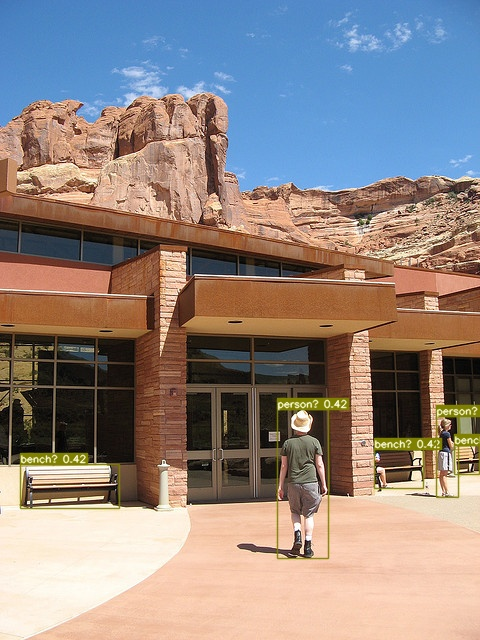

In [ ]:
cv2.imwrite("test.jpg", sample_image)

from IPython.display import Image, display

display(Image(filename="test.jpg"))

# 7. 결론

이로써 furiosa sdk를 사용하여 yolox_l 모델에 `ModelEditor` 를 적용해서 기존 보다 모델을 최적화하여 실행했고 모델 결과를 이미지로 출력해보았습니다.

`ModelEditor`를 통하여 최적화 옵션을 쉽게 적용할 수 있습니다.

(주의: 주피터 노트북 상에서 시간을 측정하면 측정 오차가 상당히 클 수 있습니다. [`nbconvert`](https://nbconvert.readthedocs.io/)를 사용해 주피터 노트북으로부터 파이썬 스크립트를 추출하고, 그 파이썬 스크립트를 실행해 시간을 측정하면 보다 안정적인 측정값을 얻을 수 있습니다.)